In [1]:
from hcipy import *
from progressbar import progressbar

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import time
import os

from progressbar import progressbar 
from FFMpegWriter import FFMpegWriter


%matplotlib inline

In [2]:
telescope_diameter = 8. # meter
central_obscuration = 1.2 # meter
central_obscuration_ratio = central_obscuration / telescope_diameter
spider_width = 0.05 # meter
oversizing_factor = 16 / 15

In [3]:
num_pupil_pixels = 240 * oversizing_factor
pupil_grid_diameter = telescope_diameter * oversizing_factor
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

VLT_aperture_generator = make_obstructed_circular_aperture(telescope_diameter,
    central_obscuration_ratio, num_spiders=4, spider_width=spider_width)

VLT_aperture = evaluate_supersampled(VLT_aperture_generator, pupil_grid, 4)


In [4]:
wavelength_wfs = 0.7e-6
wavelength_sci = 2.2e-6
wf = Wavefront(VLT_aperture, wavelength_sci)
wf.total_power = 1

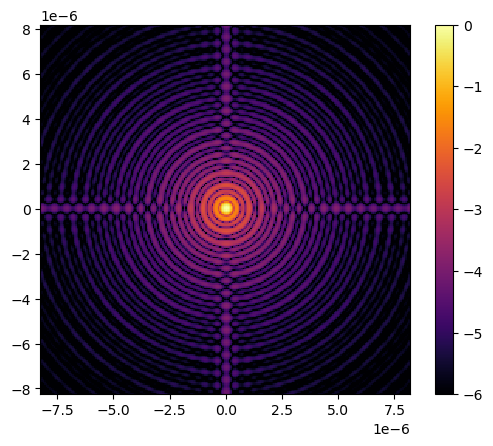

In [5]:
spatial_resolution = wavelength_sci / telescope_diameter
focal_grid = make_focal_grid(q=4, num_airy=30, spatial_resolution=spatial_resolution)

propagator = FraunhoferPropagator(pupil_grid, focal_grid)

unaberrated_PSF = propagator.forward(wf).power

imshow_field(np.log10(unaberrated_PSF / unaberrated_PSF.max()), cmap='inferno', vmin=-6)
plt.colorbar()
plt.show()

In [6]:
f_number = 50
num_lenslets = 40 # 40 lenslets along one diameter
sh_diameter = 5e-3 # m

magnification = sh_diameter / telescope_diameter
magnifier = Magnifier(magnification)

In [7]:
shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
                                                 num_lenslets, sh_diameter)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)

In [8]:
camera = NoiselessDetector(focal_grid)

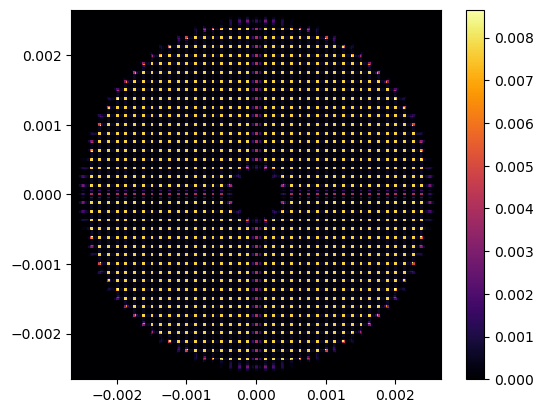

In [9]:
wf = Wavefront(VLT_aperture, wavelength_wfs)
camera.integrate(shwfs(magnifier(wf)), 1)

image_ref = camera.read_out()

imshow_field(image_ref, cmap='inferno')
plt.colorbar()
plt.show()

In [10]:
fluxes = ndimage.measurements.sum(image_ref, shwfse.mla_index, shwfse.estimation_subapertures)
flux_limit = fluxes.max() * 0.5

estimation_subapertures = shwfs.mla_grid.zeros(dtype='bool')
estimation_subapertures[shwfse.estimation_subapertures[fluxes > flux_limit]] = True

shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index, estimation_subapertures)

/var/folders/x0/ds3fx9js7_99qhqhlfn93zjm0000gn/T/ipykernel_47304/1645191210.py:1: DeprecationWarning: Please import `sum` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  fluxes = ndimage.measurements.sum(image_ref, shwfse.mla_index, shwfse.estimation_subapertures)


In [11]:
slopes_ref = shwfse.estimate([image_ref])

In [12]:
num_modes = 100

dm_modes = make_disk_harmonic_basis(pupil_grid, num_modes, telescope_diameter, 'neumann')
dm_modes = ModeBasis([mode / np.ptp(mode) for mode in dm_modes], pupil_grid)

deformable_mirror = DeformableMirror(dm_modes)

In [13]:
probe_amp = 0.01 * wavelength_wfs
response_matrix = []

wf = Wavefront(VLT_aperture, wavelength_wfs)
wf.total_power = 1

# Set up animation
plt.figure(figsize=(10, 6))
anim = FFMpegWriter('response_matrix.mp4', framerate=5)

for i in progressbar(range(num_modes)):
    slope = 0

    # Probe the phase response
    amps = [-probe_amp, probe_amp]
    for amp in amps:
        deformable_mirror.flatten()
        deformable_mirror.actuators[i] = amp

        dm_wf = deformable_mirror.forward(wf)
        wfs_wf = shwfs(magnifier(dm_wf))

        camera.integrate(wfs_wf, 1)
        image = camera.read_out()

        slopes = shwfse.estimate([image])

        slope += amp * slopes / np.var(amps)

    response_matrix.append(slope.ravel())

    # Only show all modes for the first 40 modes
    if i > 40 and (i + 1) % 20 != 0:
        continue

    # Plot mode response
    plt.clf()
    plt.suptitle('Mode %d / %d: DM shape' % (i + 1, num_modes))

    plt.subplot(1,2,1)
    plt.title('DM surface')
    im1 = imshow_field(deformable_mirror.surface, cmap='RdBu', mask=VLT_aperture)

    plt.subplot(1,2,2)
    plt.title('SH spots')
    im2 = imshow_field(image)
    plt.quiver(shwfs.mla_grid.subset(shwfse.estimation_subapertures).x,
        shwfs.mla_grid.subset(shwfse.estimation_subapertures).y,
        slope[0,:], slope[1,:],
        color='white')

    anim.add_frame()

response_matrix = ModeBasis(response_matrix)

plt.close()
anim.close()

# Show created animation
anim

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

Input #0, image2pipe, from 'fd:':
  Duration: N/A, bitrate: N/A
  Stream #0:0: Video: png, rgba(pc, gbr/unknown/unknown), 1000x600 [SAR 3937:3937 DAR 5:3], 5 fps, 5 tbr, 5 tbn
[out#0/mp4 @ 0x112604680] Codec AVOption crf (Select the quality for constant quality mode) has not been used for any stream. The most likely reason is either wrong type (e.g. a video option with no video streams) or that it is a private option of some encoder which was not actually used for any stream.
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libopenh264))
[libopenh264 @ 0x142706d30] [OpenH264] this = 0x0x142710430, Warning:layerId(0) doesn't support profile(578), change to UNSPECIFIC profile
[libopenh264 @ 0x142706d30] [OpenH264] this = 0x0x142710430, Warning:bEnableFrameSkip = 0,bitrate can't be controlled for RC_QUALITY_MODE,RC_BITRATE_MODE and RC_TIMESTAMP_MODE without enabling skip frame.
[libopenh264 @ 0x142706d30] [OpenH264] this = 0x0x142710430, Warning:Change QP Range from(0,51) to (

[############################################################] 100/100


[out#0/mp4 @ 0x112604680] video:2101kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.048380%
frame=   44 fps=7.7 q=-0.0 Lsize=    2102kB time=00:00:08.60 bitrate=2002.6kbits/s speed= 1.5x    


In [14]:
rcond = 1e-3

reconstruction_matrix = inverse_tikhonov(response_matrix.transformation_matrix, rcond=rcond)
print(reconstruction_matrix.shape)

(100, 2432)


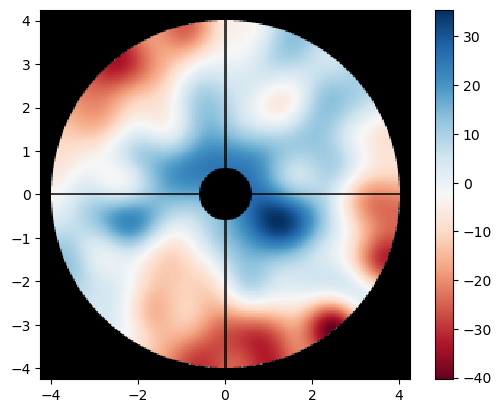

In [15]:
# Put actuators at random values, putting a little more power in low-order modes
deformable_mirror.actuators = np.random.randn(num_modes) / (np.arange(num_modes) + 10)

# Normalize the DM surface so that we get a reasonable surface RMS.
deformable_mirror.actuators *= 0.3 * wavelength_sci / np.std(deformable_mirror.surface)

imshow_field(deformable_mirror.phase_for(wavelength_wfs), mask=VLT_aperture, cmap='RdBu')
plt.colorbar()
plt.show()

In [25]:
# seeing = 1.5 #arcsec (r_naught=0.8m)
# seeing = 1.3 #arcsec (r_naught=0.8m)
seeing = 0.5 #arcsec 

outer_scale = 40 # meter
# r0=seeing_to_fried_parameter(seeing)
# print (0.005 * (0.8 / r0))



fried_parameter = seeing_to_fried_parameter(seeing)
# tau0 = 0.0025 # arbitrary, does Lick Observatory have a value?
tau0 = 0.015 # from tutorial
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
velocity = 0.314 * fried_parameter / tau0

print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))

r0   = 20.2cm
L0   = 40.0m
tau0 = 15.0ms
v    = 4.2m/s


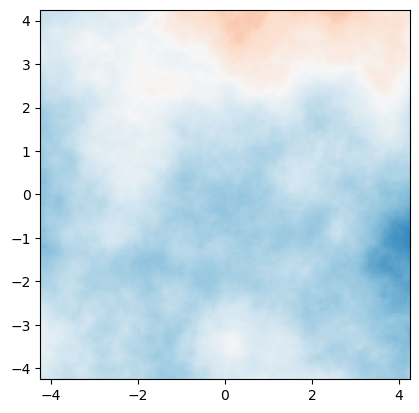

In [26]:
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

phase_screen_phase = layer.phase_for(wavelength_wfs) # in radian
phase_screen_opd = phase_screen_phase * (wavelength_wfs / (2 * np.pi)) * 1e6

imshow_field(phase_screen_opd, vmin=-6, vmax=6, cmap='RdBu')

In [27]:
plt.figure(figsize=(5, 4))
anim = FFMpegWriter('atmospheric_turbulence.mp4', framerate=5)

t_end = 1
n = 51
for t in np.linspace(0, t_end, n):
    layer.t = t

    phase_screen_phase = layer.phase_for(wavelength_wfs) # in radian
    phase_screen_opd = phase_screen_phase * (wavelength_wfs / (2 * np.pi)) * 1e6 # in um

    plt.clf()
    plt.suptitle('Time %.3f s' % t)

    plt.subplot(1,1,1)
    plt.title('Turbulent wavefront [$\\mu$m]')
    imshow_field(phase_screen_opd, vmin=-6, vmax=6, cmap='RdBu')
    plt.colorbar()

    anim.add_frame()

plt.close()
anim.close()

# Show created animation
anim


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

In [28]:
zero_magnitude_flux = 3.9e10 #3.9e10 photon/s for a mag 0 star
stellar_magnitude = 5
delta_t = 1e-3 # sec, so a loop speed of 1kHz.

wf_wfs = Wavefront(VLT_aperture, wavelength_wfs)
wf_sci = Wavefront(VLT_aperture, wavelength_sci)

wf_wfs.total_power = zero_magnitude_flux * 10**(-stellar_magnitude / 2.5)
wf_sci.total_power = zero_magnitude_flux * 10**(-stellar_magnitude / 2.5)

print("Photon flux per WFS frame {:g}".format(wf_wfs.total_power * delta_t))

Photon flux per WFS frame 390000


In [29]:
layer.reset()
deformable_mirror.flatten()

gain = 0.3
leakage = 0.01
num_iterations = 100
burn_in_iterations = 5

coro = PerfectCoronagraph(VLT_aperture, 4)

long_exposure = focal_grid.zeros()
long_exposure_coro = focal_grid.zeros()

# Set up animation
plt.figure(figsize=(8, 8))
anim = FFMpegWriter('AO_simulation_with_turbulence.mp4', framerate=10)

for timestep in progressbar(range(num_iterations)):
    layer.t = timestep * delta_t

    # Propagate through atmosphere and deformable mirror.
    wf_wfs_after_atmos = layer(wf_wfs)
    wf_wfs_after_dm = deformable_mirror(wf_wfs_after_atmos)

    # Propagate through SH-WFS
    wf_wfs_on_sh = shwfs(magnifier(wf_wfs_after_dm))

    # Propagate the NIR wavefront
    wf_sci_focal_plane = propagator(deformable_mirror(layer(wf_sci)))
    wf_sci_coro = propagator(coro(deformable_mirror(layer(wf_sci))))

    # Read out WFS camera
    camera.integrate(wf_wfs_on_sh, delta_t)
    wfs_image = camera.read_out()
    wfs_image = large_poisson(wfs_image).astype('float')

    # Accumulate long-exposure image
    if timestep >= burn_in_iterations:
        long_exposure += wf_sci_focal_plane.power / (num_iterations - burn_in_iterations)
        long_exposure_coro += wf_sci_coro.power / (num_iterations - burn_in_iterations)

    # Calculate slopes from WFS image
    slopes = shwfse.estimate([wfs_image + 1e-10])
    slopes -= slopes_ref
    slopes = slopes.ravel()

    # Perform wavefront control and set DM actuators
    print ("actuator update:", reconstruction_matrix.dot(slopes))
    deformable_mirror.actuators = (1 - leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(slopes)

    # Plotting
    if timestep % 20 == 0:
        plt.clf()

        plt.suptitle('Timestep %d / %d' % (timestep, num_iterations))

        plt.subplot(2,2,1)
        plt.title('DM surface [$\\mu$m]')
        imshow_field(deformable_mirror.surface * 1e6, cmap='RdBu', vmin=-2, vmax=2, mask=VLT_aperture)
        plt.colorbar()

        plt.subplot(2,2,2)
        plt.title('WFS image [counts]')
        imshow_field(wfs_image, cmap='inferno')
        plt.colorbar()

        plt.subplot(2,2,3)
        plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')
        imshow_field(np.log10(wf_sci_focal_plane.power/ wf_sci_focal_plane.power.max()), vmin=-6, vmax=0, cmap='inferno') #
        plt.colorbar()

        if timestep >= burn_in_iterations:
            plt.subplot(2,2,4)
            plt.title('Average PSF at 2.2$\\mu$m [log]')
            imshow_field(np.log10(long_exposure_coro / long_exposure.max()), vmin=-6, vmax=0, cmap='inferno')
            plt.colorbar()

        anim.add_frame()

plt.close()
anim.close()

# Show created animation
anim

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/opt/homebrew/anaconda3/envs/hcipy_env --cc=arm64-apple-darwin20.0.0-clang --ar=arm64-apple-darwin20.0.0-ar --nm=arm64-apple-darwin20.0.0-nm --ranlib=arm64-apple-darwin20.0.0-ranlib --strip=arm64-apple-darwin20.0.0-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-libopenjpeg --enable-libvorbis --enable-pthreads --enable-libtesseract --enable-libvpx --enable-librsvg
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16

actuator update: [ 2.27684493e-07 -3.04776755e-07  1.78304645e-07  2.53143800e-08
  3.36692436e-07 -2.48911301e-08  6.61993527e-08 -3.23266865e-08
 -1.04958545e-07  5.69574897e-08  3.48171607e-08  1.51238270e-08
 -9.01346453e-08  1.02820691e-07 -1.88604444e-07  8.15509685e-08
 -9.29470606e-08  6.81466971e-08 -2.18383654e-08 -3.24827852e-09
  3.26377996e-08 -7.73876713e-08 -3.34729033e-08  4.85627699e-08
  5.84863837e-08 -5.05798955e-08 -1.81237559e-08 -2.44793292e-08
 -9.68135202e-08  4.92322535e-08 -3.06025677e-08  1.06225573e-08
 -1.35083861e-08  1.20752381e-08 -1.46571282e-08 -2.55519723e-08
 -5.38256762e-09  2.45464870e-08  1.93717934e-08 -4.22768709e-08
 -2.95566127e-08 -6.60163816e-09  7.15028080e-08 -6.26864040e-08
  2.16799280e-08  2.76061268e-08 -4.03729285e-08 -1.19360227e-08
  8.72261645e-09  4.47682105e-08  4.00404707e-08  1.24575414e-08
  4.15061798e-08 -1.70352820e-08 -8.49844353e-08  2.03089756e-08
  4.29716342e-09  4.47473061e-08  8.12347436e-09 -6.33429179e-08
 -6.2646

Input #0, image2pipe, from 'fd:':
  Duration: N/A, bitrate: N/A
  Stream #0:0: Video: png, rgba(pc, gbr/unknown/unknown), 800x800 [SAR 3937:3937 DAR 1:1], 10 fps, 10 tbr, 10 tbn
[out#0/mp4 @ 0x10ae048a0] Codec AVOption crf (Select the quality for constant quality mode) has not been used for any stream. The most likely reason is either wrong type (e.g. a video option with no video streams) or that it is a private option of some encoder which was not actually used for any stream.
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libopenh264))
[libopenh264 @ 0x10ae059a0] [OpenH264] this = 0x0x10c107f00, Warning:layerId(0) doesn't support profile(578), change to UNSPECIFIC profile
[libopenh264 @ 0x10ae059a0] [OpenH264] this = 0x0x10c107f00, Warning:bEnableFrameSkip = 0,bitrate can't be controlled for RC_QUALITY_MODE,RC_BITRATE_MODE and RC_TIMESTAMP_MODE without enabling skip frame.
[libopenh264 @ 0x10ae059a0] [OpenH264] this = 0x0x10c107f00, Warning:Change QP Range from(0,51) to